In [2]:
from main import *

check_torch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
case1, case2, synthetic1, synthetic2 = load_all_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.3.1.post300 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------

Name              : Source                : Shape
----------------- : --------------------- : -----------
Field Case 1      : (North Africa)        : (2399, 12)
Field Case 2      : (North Sea)           : (11143, 12)
Synthetic Case 1  : (Laminated)           : (801, 14)
Synthetic Case 2  : (Laminated+Dispersed) : (415, 10)


In [4]:
def error_metrics(df):
    mse_rv = mean_squared_error(df['Rv'], df['Rv_sim'])
    mse_rh = mean_squared_error(df['Rh'], df['Rh_sim'])
    r2_rv = r2_score(df['Rv'], df['Rv_sim'])*100
    r2_rh = r2_score(df['Rh'], df['Rh_sim'])*100
    sterr_rv = np.mean(np.abs(df['Rv']-df['Rv_sim'])) / np.std(np.abs(df['Rv']-df['Rv_sim']))
    sterr_rh = np.mean(np.abs(df['Rh']-df['Rh_sim'])) / np.std(np.abs(df['Rh']-df['Rh_sim']))
    mape_rv = mean_absolute_percentage_error(df['Rv'], df['Rv_sim']) * 100
    mape_rh = mean_absolute_percentage_error(df['Rh'], df['Rh_sim']) * 100
    print('Mean Squared Error - Rv: {:.4f}  | Rh: {:.4f}'.format(mse_rv, mse_rh))
    print('R2 Score           - Rv: {:.3f}  | Rh: {:.3f}'.format(r2_rv, r2_rh))
    print('Standard Error     - Rv: {:.4f}  | Rh: {:.4f}'.format(sterr_rv, sterr_rh))
    print('MAPE               - Rv: {:.3f}%  | Rh: {:.3f}%'.format(mape_rv, mape_rh))
    return None

In [256]:
well1 = case1[['GR', 'AT90', 'Rv','Rh']].dropna()
well1['Csh_lin'] = ((well1['GR'] - well1['GR'].min()) / (well1['GR'].max() - well1['GR'].min()))
well1['Csh_lin'] = np.clip(well1['Csh_lin'], 0.025, 0.975)

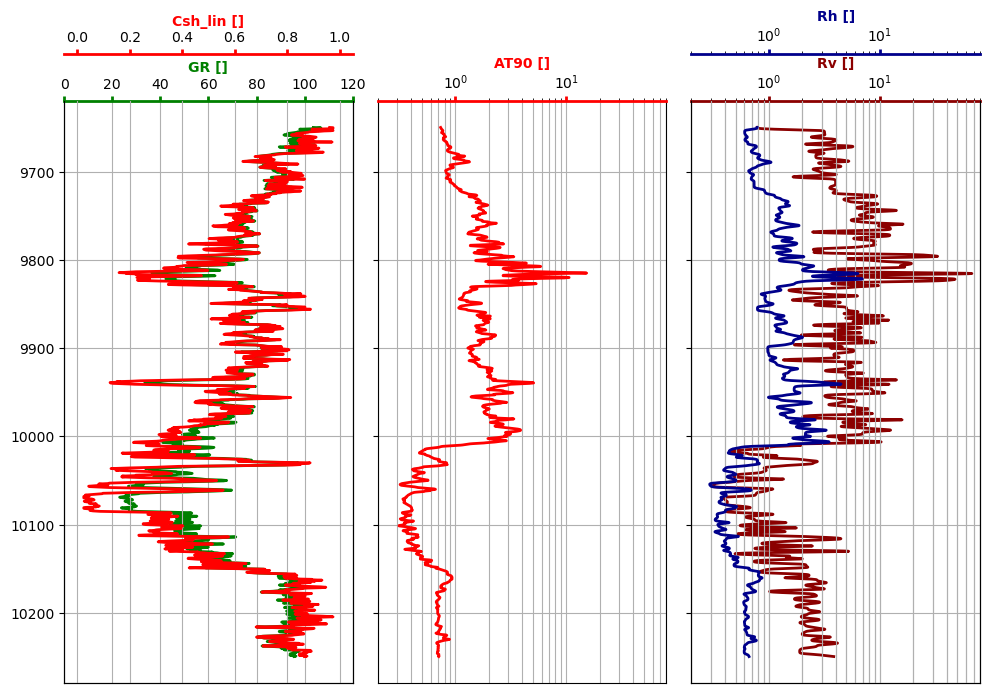

In [257]:
fig, axs = plt.subplots(1, 3, figsize=(10,7), sharey=True)
ax1, ax2, ax3 = axs

ax11 = ax1.twiny()
ax31 = ax3.twiny()

plot_curve(ax1, well1, 'GR', 0, 120, 'g')
plot_curve(ax11, well1, 'Csh_lin', -0.05, 1.05, 'r', pad=8)
plot_curve(ax2, well1, 'AT90', 0.2, 80, 'r', semilog=True)
plot_curve(ax3, well1, 'Rv', 0.2, 80, 'darkred', semilog=True)
plot_curve(ax31, well1, 'Rh', 0.2, 80, 'darkblue', semilog=True, pad=8)

ax1.invert_yaxis()
plt.tight_layout()
plt.show()

In [332]:
def objective(variables, *args):
    Rs = variables   
    Rh, Rhsh, Csh = args[0], args[1], args[2]
    loss = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)
    return linalg.norm(loss,2) + 1e-3*linalg.norm(variables,2)

def jacobian(variables, *args):
    return Jacobian(lambda x: objective(x, *args))(variables).ravel()

def hessian(variables, *args):
    return Hessian(lambda x: objective(x, *args))(variables)

sol = []
for i, row in well1.iterrows():
    Rh_value   = row['AT90']
    Rhsh_value = 1
    Rvsh_value = 10
    Csh_value  = row['Csh_lin'] #row['Csh_lin']

    res = optimize.minimize(objective,
                            x0          = 3,
                            args        = (Rh_value, Rhsh_value, Csh_value),
                            method      = 'L-BFGS-B',
                            bounds      = [(1e-3, 100)],
                            #jac         = jacobian,
                            #hess        = hessian,
                            tol         = 1e-6,
                            options     = {'maxiter':200},
                            )
    Rss_pred = res.x.item()
    sol.append({'RH':Rh_value, 'Csh_pred':Csh_value, 'Rss_pred':Rss_pred,
                'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                'Rh_sim': 1/(Csh_value/Rhsh_value + (1-Csh_value)/Rss_pred),
                'Rv_sim': -3 + Csh_value*Rvsh_value + (1-Csh_value)*Rss_pred,
                'Rh_err': 100*np.abs(Rh_value - 1/(Csh_value/Rhsh_value + (1-Csh_value)/Rss_pred))})
    
well1_gb = pd.DataFrame(sol, index=well1.index)
well1_sol = well1.join(well1_gb)

In [333]:
true = well1['Rh']
pred = well1_sol['Rh_sim']

mse = mean_squared_error(true, pred)
r2 = r2_score(true, pred)*100
sterr = np.mean(np.abs(true-pred)) / np.std(np.abs(true-pred))
mape = mean_absolute_percentage_error(true, pred) * 100
print('MSE: {} | R2: {} | STERR: {} | MAPE: {}'.format(mse, r2, sterr, mape))

MSE: 0.11677383638829544 | R2: 79.99740803950819 | STERR: 0.7600613308661813 | MAPE: 17.49091502987761


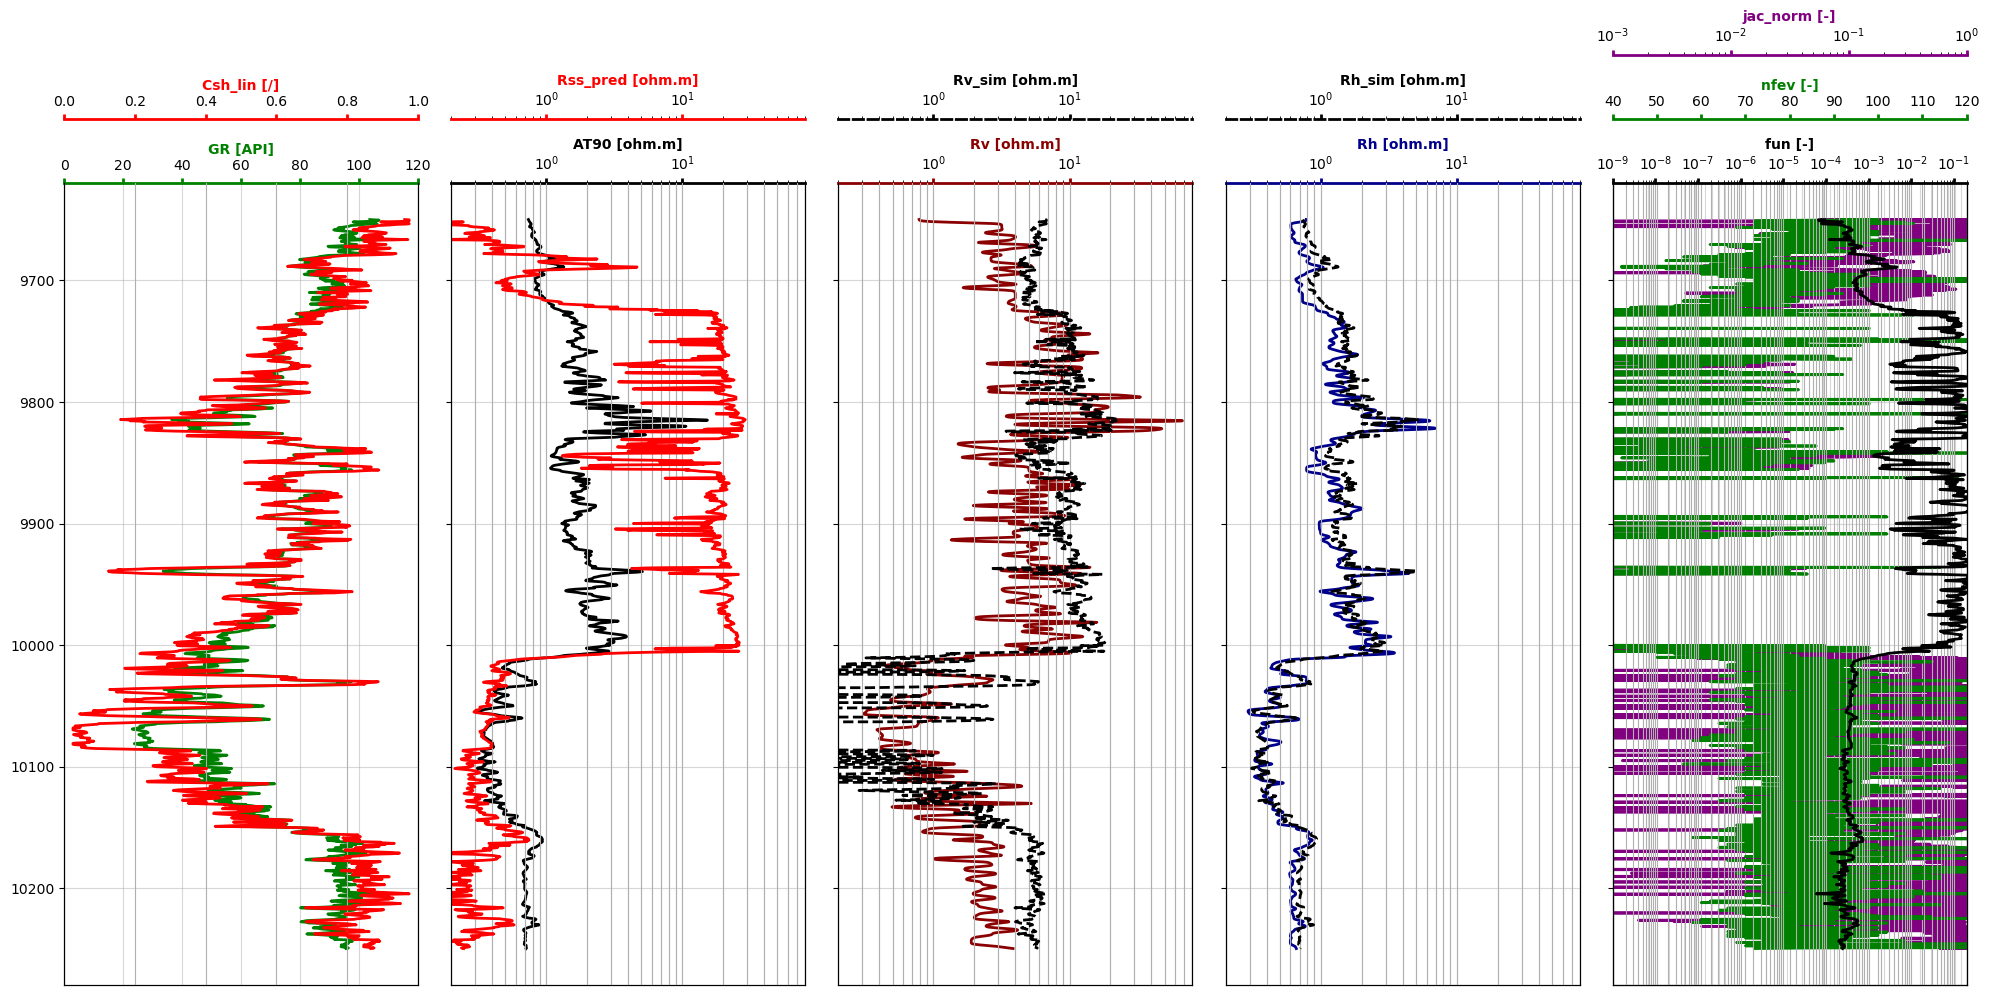

In [334]:
fig, axs = plt.subplots(1, 5, figsize=(20,10), sharey=True)
ax1, ax2, ax3, ax4, ax5 = axs

ax11 = ax1.twiny()
ax21 = ax2.twiny()

plot_curve(ax1, well1, 'GR', units='API', color='g', lb=0, ub=120)
plot_curve(ax11, well1_sol, 'Csh_lin', units='/', color='r', lb=0, ub=1, pad=8)

plot_curve(ax2, well1, 'AT90', units='ohm.m', color='k', lb=0.2, ub=80, semilog=True)
plot_curve(ax21, well1_sol, 'Rss_pred', units='ohm.m', color='r', lb=0.2, ub=80, semilog=True, pad=8)

ax31 = ax3.twiny()
plot_curve(ax3, well1, 'Rv', units='ohm.m', color='darkred', lb=0.2, ub=80, semilog=True)
plot_curve(ax31, well1_sol, 'Rv_sim', units='ohm.m', color='k', ls='--', lb=0.2, ub=80, semilog=True, pad=8)
#plot_curve(ax42, well1_sol, 'Rv_err', units='%', color='firebrick', fill=True, lb=0, ub=5, pad=16)

ax41 = ax4.twiny()
plot_curve(ax4, well1, 'Rh', units='ohm.m', color='darkblue', lb=0.2, ub=80, semilog=True)
plot_curve(ax41, well1_sol, 'Rh_sim', units='ohm.m', color='k', ls='--', lb=0.2, ub=80, semilog=True, pad=8)
#plot_curve(ax52, well1_sol, 'Rh_err', units='%', color='navy', fill=True, lb=0, ub=100, pad=16)

ax51, ax52 = ax5.twiny(), ax5.twiny()
plot_curve(ax52, well1_sol, 'fun', units='-', color='k', lb=1e-9, ub=0.2, semilog=True)
plot_curve(ax51, well1_sol, 'nfev', units='-', color='g', lb=40, ub=120, pad=8)
plot_curve(ax5, well1_sol, 'jac_norm', units='-', color='purple', lb=1e-3, ub=1, semilog=True, pad=16)

[a.grid(True, which='both', alpha=0.5) for a in axs]
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***
# END